# Reading May and Beg. of June Data

In [30]:
%matplotlib inline
#from matplotlib import pyplot as pt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import seaborn as sns

from datetime import datetime

import os
import glob

In [31]:
def load_local_data():
    csv_path = os.path.join(os.getcwd(), 'data-gala/*.txt')
    all_files = glob.glob(csv_path)
    
    all_files = ['/home/lucia/lucia/metis/01-benson/data-gala/01_turnstile_150502.txt',
                 '/home/lucia/lucia/metis/01-benson/data-gala/02_turnstile_150509.txt',
                 '/home/lucia/lucia/metis/01-benson/data-gala/03_turnstile_150516.txt',
                 '/home/lucia/lucia/metis/01-benson/data-gala/04_turnstile_150523.txt',
                 '/home/lucia/lucia/metis/01-benson/data-gala/05_turnstile_150530.txt',
                 '/home/lucia/lucia/metis/01-benson/data-gala/06_turnstile_150606.txt']
    
  #  print 'reading data from files:'
  #  for f in all_files:
  #      print f
    
    data = pd.concat((pd.read_csv(f) for f in all_files))
    
    # strip whitespace off column headers (eg 'EXITS               ' has trailing spaces)
    data = data.rename(columns=lambda x: x.strip())
    return data

data = load_local_data()
print "\ngot %i rows total." % len(data)
#data.head()


got 1152582 rows total.


# How many unique stations do we have in our set?

In [32]:
# How many stations are there?
unique_stations = data.STATION.unique()
print len(unique_stations)

384


# Transforming data: creating datetime, entries and exits diffs, and sums

In [33]:
# make a datetime column
data['DATETIME'] = pd.to_datetime(data.DATE + ' ' + data.TIME, format="%m/%d/%Y %H:%M:%S")
data.head()
data.tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
191727,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2015,05:00:00,REGULAR,5554,212,2015-06-05 05:00:00
191728,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2015,09:00:00,REGULAR,5554,212,2015-06-05 09:00:00
191729,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2015,13:00:00,REGULAR,5554,212,2015-06-05 13:00:00
191730,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2015,17:00:00,REGULAR,5554,212,2015-06-05 17:00:00
191731,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2015,21:00:00,REGULAR,5554,212,2015-06-05 21:00:00


In [58]:
# Calclate new columns ENTRIES_DIFF and EXITS_DIFF for each unique turnstile/device.
# The first entry is NaN, the rest of the entries are the difference from the previous.
turnstile_groupby = data.groupby(['C/A','UNIT','SCP','STATION'])
for diff_field in ('ENTRIES','EXITS'):
    data[diff_field + '_DIFF'] = turnstile_groupby[diff_field].transform(pd.Series.diff)
data.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,ENTRIES_DIFF,EXITS_DIFF
0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,00:00:00,REGULAR,5106770,1729635,2015-04-25 00:00:00,NaN,NaN
1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,04:00:00,REGULAR,5106810,1729649,2015-04-25 04:00:00,40.0,14.0
2,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,08:00:00,REGULAR,5106835,1729680,2015-04-25 08:00:00,25.0,31.0
3,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,12:00:00,REGULAR,5106961,1729784,2015-04-25 12:00:00,126.0,104.0
4,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,16:00:00,REGULAR,5107250,1729858,2015-04-25 16:00:00,289.0,74.0
5,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,20:00:00,REGULAR,5107620,1729914,2015-04-25 20:00:00,370.0,56.0
6,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/26/2015,00:00:00,REGULAR,5107793,1729955,2015-04-26 00:00:00,173.0,41.0
7,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/26/2015,04:00:00,REGULAR,5107815,1729964,2015-04-26 04:00:00,22.0,9.0
8,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/26/2015,08:00:00,REGULAR,5107844,1729991,2015-04-26 08:00:00,29.0,27.0
9,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/26/2015,12:00:00,REGULAR,5107912,1730068,2015-04-26 12:00:00,68.0,77.0


In [35]:
# sanity check for getting the differences:
nan_entries = len(data[data.ENTRIES_DIFF.isnull()])
total_unique_turnstiles = len(turnstile_groupby)
print 'the number of NaN entries should equal the total unique turnstiles.'
print nan_entries, total_unique_turnstiles

assert nan_entries == total_unique_turnstiles

the number of NaN entries should equal the total unique turnstiles.
4568 4568


In [36]:
# learning how to deal with NA values
print len(data[data.ENTRIES_DIFF.isnull()])
print len(data.dropna())
print len(data)

4568
1148014
1152582


In [76]:
# dropping NA values and all non-REGULAR recordings
# calculating percentage of "regular" values vs. all nonNA values
reg_data = data.dropna()
reg_data = reg_data[ reg_data['DESC'] == 'REGULAR']
len(reg_data)/float(len(data.dropna()))

0.9968981214514806

In [77]:
# FYI: there are about 48% of rows that are recorded at times other than 0,4,8,12,16 or 20 hours !!! 
filtered_times = reg_data[ reg_data['TIME'].isin(['00:00:00','04:00:00','08:00:00','12:00:00','16:00:00','20:00:00'])]
print filtered_times['TIME'].unique()
print reg_data['TIME'].unique()
print (len(reg_data)-len(filtered_times))/float(len(reg_data))

['04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00' '00:00:00']
['04:00:00' '08:00:00' '12:00:00' ..., '19:09:21' '08:16:33' '07:37:13']
0.483329590643


# Finding Max Entries Stations

In [78]:
station_groupby = reg_data.groupby(['STATION'])
top_20 = station_groupby['ENTRIES_DIFF','EXITS_DIFF'].sum().sort('ENTRIES_DIFF', ascending=0)
top_20 = top_20[:20]
print top_20

                 ENTRIES_DIFF    EXITS_DIFF
STATION                                    
149 ST-3 AVE     1.942124e+09  1.241344e+09
LEXINGTON-53 ST  1.543446e+09  7.269518e+08
116 ST-COLUMBIA  1.153612e+09  2.341994e+08
59 ST            1.038579e+09  7.262767e+08
1 AVE            9.389433e+08  9.861545e+08
110 ST-CPN       7.357633e+08  7.690074e+08
174 ST           6.855274e+08  4.691848e+06
CANAL ST         4.537113e+08  8.210010e+08
14 ST-6 AVE      3.683715e+08  3.350736e+08
GRAND ST         2.184926e+08  1.398768e+09
18 ST            2.008699e+08  7.354519e+08
5 AVE-59 ST      1.140999e+08 -6.611688e+06
PELHAM BAY PARK  8.417113e+07  3.372508e+07
34 ST-HERALD SQ  8.342207e+07 -2.034104e+06
ZEREGA AVE       5.181220e+07 -2.302811e+06
170 ST           5.097030e+07  3.934740e+05
33 ST/RAWSON ST  5.081821e+07  1.712046e+07
28 ST            1.251251e+07  2.689071e+08
34 ST-PENN STA   6.265906e+06  5.496082e+06
86 ST            4.303861e+06  3.391643e+06


/home/lucia/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [79]:
top_20_entries = top_20.ENTRIES_DIFF
#print top_20_entries

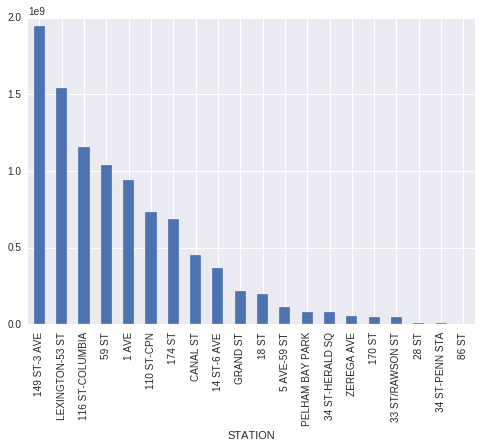

In [80]:
top_20_entries.plot(kind='bar')

# Station day time heatmap

In [81]:
# Looking only at measurements that occurred at the 0,4,8,12,16,20-hour windows.
# Working with the filtered_times dataset
data_dt = filtered_times[['STATION', 'DATETIME', 'ENTRIES_DIFF','EXITS_DIFF']]

In [82]:
data_dt['DAY'] = data_dt['DATETIME'].dt.dayofweek
data_dt['TIME'] = data_dt['DATETIME'].dt.time
data_dt.head()

/home/lucia/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/lucia/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,STATION,DATETIME,ENTRIES_DIFF,EXITS_DIFF,DAY,TIME
1,LEXINGTON AVE,2015-04-25 04:00:00,40.0,14.0,5,04:00:00
2,LEXINGTON AVE,2015-04-25 08:00:00,25.0,31.0,5,08:00:00
3,LEXINGTON AVE,2015-04-25 12:00:00,126.0,104.0,5,12:00:00
4,LEXINGTON AVE,2015-04-25 16:00:00,289.0,74.0,5,16:00:00
5,LEXINGTON AVE,2015-04-25 20:00:00,370.0,56.0,5,20:00:00


In [85]:
stations_dt = data_dt.groupby(['STATION','DAY','TIME'])
all_dt = stations_dt['ENTRIES_DIFF','EXITS_DIFF'].mean()
all_dt.head(12)

ENTRIES_DIFF  EXITS_DIFF
STATION DAY TIME                              
1 AVE   0   00:00:00     84.600000   97.683333
            04:00:00     20.516667   19.983333
            08:00:00    145.033333  268.100000
            12:00:00    482.800000  528.516667
            16:00:00    464.166667  403.650000
            20:00:00    629.500000  630.733333
        1   00:00:00    312.666667  332.366667
            04:00:00     16.733333   17.333333
            08:00:00    199.483333  341.233333
            12:00:00    562.900000  585.100000
            16:00:00    483.866667  431.733333
            20:00:00    708.466667  692.550000

# One station -- 1 AVE

In [86]:
station = '1 AVE'
one_station = data_dt[ data_dt['STATION'] == station ]
one_groupby = one_station.groupby(['DAY','TIME'])
#one_dt = one_groupby['ENTRIES_DIFF','EXITS_DIFF'].mean()
one_dt = one_groupby['ENTRIES_DIFF'].mean().reset_index()
print one_dt[1:3]

   DAY      TIME  ENTRIES_DIFF
1    0  04:00:00     20.516667
2    0  08:00:00    145.033333


In [93]:
# changing format of the pandas data frame from three-columns to 2-column indices and third-column as values
# of a matrix
one_dt_heatmap = one_dt.set_index(['DAY', 'TIME']).ENTRIES_DIFF.unstack(0)
one_dt_heatmap[1:6]

DAY,0,1,2,3,4,5,6
TIME,,,,,,,
04:00:00,20.516667,16.733333,21.300000,24.000000,3.346667e+01,49.616667,48.300000
08:00:00,145.033333,199.483333,191.483333,190.576271,1.493333e+02,19.350000,15.366667
12:00:00,482.800000,562.900000,583.500000,580.762712,1.586135e+07,84.600000,68.900000
16:00:00,464.166667,483.866667,497.733333,497.633333,5.401000e+02,150.116667,122.100000
20:00:00,629.500000,708.466667,732.383333,718.363636,7.359333e+02,131.933333,120.566667


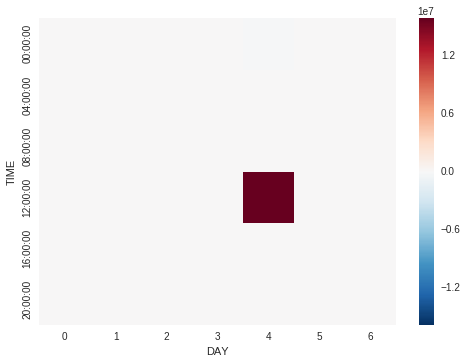

In [91]:
# The data is VERY MESSY -- shows unreasonably high values for day 4, round noon time. 
# Wonder if we could filter these peaks somehow.
sns.heatmap(one_dt_heatmap)

# Group by station and datetime

In [94]:
# group by station name and datetime,
station_time_groupby = reg_data.groupby(['STATION','DATETIME'])

# data.join(station_time_groupby['ENTRIES_DIFF','EXITS_DIFF'].sum(), on=['STATION','DATETIME'], rsuffix='_r')
station_time_groupby['ENTRIES_DIFF','EXITS_DIFF'].sum().head()

ENTRIES_DIFF  EXITS_DIFF
STATION DATETIME                                     
1 AVE   2015-04-25 04:00:00           3.0        76.0
        2015-04-25 08:00:00           2.0        53.0
        2015-04-25 12:00:00           2.0        54.0
        2015-04-25 16:00:00           4.0        57.0
        2015-04-25 20:00:00           0.0        41.0

In [95]:
# The dataset also leads to many negative diff values and unreasonably high negative diff peaks (-1.4x10^9)
data[data.ENTRIES_DIFF < 0].min()

C/A                            A011
UNIT                           R007
SCP                        00-00-00
STATION                       1 AVE
LINENAME                          1
DIVISION                        BMT
DATE                     04/25/2015
TIME                       00:00:00
DESC                     RECOVR AUD
ENTRIES                           0
EXITS                             0
DATETIME        2015-04-25 04:00:00
ENTRIES_DIFF           -1.40381e+09
EXITS_DIFF             -1.11135e+07
dtype: object